**Introduction:** <br>
The variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home. Great for practicing skills such as:

Creative feature engineering
Advanced regression techniques like random forest and gradient boosting

1. Import Libraries
1. Load Data
1. Analyse Target variable
1. Correlation Analysis
1. Multicollinearity
1. Most correlated Features
1. Visulization
1. Handling Missing value
1. Filling missing value
1. Feature Engineering     <br>
   1.Box Cox Transformation<br>
   2.Cross validation<br>
   3.Regularization Model<br>
   4.Boosting<br>
   5.Stacking<br>
1. Final Training and Prediction
1. Submission

**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid',color_codes =True)
sns.set(font_scale=1)

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [3]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

from sklearn import linear_model
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

ModuleNotFoundError: No module named 'lightgbm'

In [4]:
from google.colab import files
Uploaded = files.upload()

Saving train.csv to train.csv


In [0]:
import io

train_df = pd.read_csv(io.BytesIO(Uploaded['train.csv']))

In [6]:
from google.colab import  files
Uploaded = files.upload()

Saving test.csv to test.csv


In [0]:
import io
test_df = pd.read_csv(io.BytesIO(Uploaded['test.csv']))

In [0]:
#train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')

In [0]:
#test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [6]:
train_df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [8]:
train_df.get_dtype_counts()

float64     3
int64      35
object     43
dtype: int64

In [9]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


So what can we see till now.<br>
we have total 81 variables for train and 80 for test variable<br>
we don't have SalePrice variable for test variable because this will be our task to infer SalePrice for test set by learning from train set.<br>
So SalePrice is our target variable and rest of the variables are our predictor variables.

**We need to check below assumtions:**

**Normality** - A normal distribution is an arrangement of a data set in which most values cluster in the middle of the range and the rest taper off symmetrically toward either extreme.

A graphical representation of a normal distribution is sometimes called a bell curve because of its flared shape.

**Homoscedasticity** - This assumption means that the variance around the regression line is the same for all values of the predictor variable

**Linearity**- The most common way to assess linearity is to examine scatter plots and search for linear patterns. If patterns are not linear, it would be worthwhile to explore data transformations. However, we'll not get into this because most of the scatter plots we've seen appear to have linear relationships.

**Absence of correlated errors(Multicollineraty)** - Correlated errors, like the definition suggests, happen when one error is correlated to another. For instance, if one positive error makes a negative error systematically, it means that there's a relationship between these variables. This occurs often in time series, where some patterns are time related. We'll also not get into this. However, if you detect something, try to add a variable that can explain the effect you're getting. That's the most common solution for correlated errors.

**Analyse Target variable**

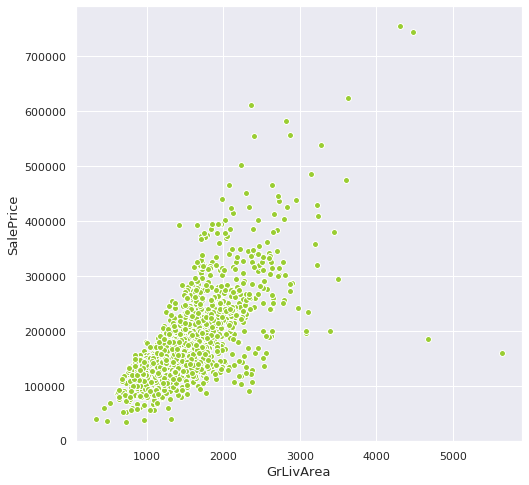

In [10]:

plt.figure(figsize=(8,8))
plt.scatter(x = train_df['GrLivArea'], y = train_df['SalePrice'],color='yellowgreen',edgecolor ='white')

plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

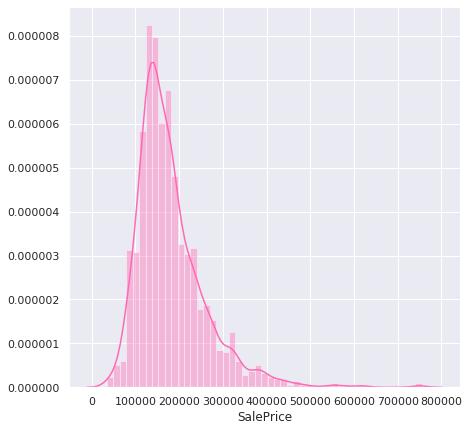

In [11]:
plt.figure(figsize=(7,7))
sns.distplot(train_df['SalePrice'],color = 'hotpink',hist = 25)

In [12]:
#skewness and kurtosis
print("Skewness: %f" % train_df['SalePrice'].skew())
print("Kurtosis: %f" % train_df['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


### Distribution of Target value

Shows Positive skewness

SalePrice is not uniformly distributed and is skewed towards the right . Therefore , we use log1p to remove the skewness .

**Skewedness and Kurtosis: **<br>
Skewedness:

A skewness of zero or near zero indicates a symmetric distribution. A negative value for the skewness indicate a left skewness (tail to the left) A positive value for te skewness indicate a right skewness (tail to the right) Skewness
is the degree of distortion from the symmetrical bell curve or the normal curve. So, a symmetrical distribution will have a skewness of "0". There are two types of Skewness: Positive and Negative. Positive Skewness(similar to our target variable distribution) means the tail on the right side of the distribution is longer and fatter. In positive Skewness the mean and median will be greater than the mode. This is similar to this dataset. 

Kourtosis is a measure of how extreme observations are in a dataset. The greater the kurtosis coefficient , the more peaked the distribution around the mean .<br>


There are three types of Kurtosis: Mesokurtic, Leptokurtic and Platykurtic.<br>
Mesokurtic is similar to normal curve with the standard value of 3. This means that the extreme values of this distrubution is similar to that of a normal distribution.<br>
Leptokurtic Example of leptokurtic distributions are the T-distributions with small degrees of freedom.<br>
Platykurtic: Platykurtic describes a particular statistical distribution with thinner tails than a normal distribution. Because this distribution has thin tails, it has fewer outliers (e.g., extreme values three or more standard deviations from the mean) than do mesokurtic and leptokurtic distributions.

In [0]:
#Need to remove Outliers
train_df = train_df[train_df.GrLivArea < 4500]
train_df.reset_index(drop=True, inplace=True)
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])
y = train_df['SalePrice'].reset_index(drop=True)

In [14]:
train_df.shape

(1458, 81)

In [15]:
#skewness and kurtosis
print("Skewness: %f" % train_df['SalePrice'].skew())
print("Kurtosis: %f" % train_df['SalePrice'].kurt())

Skewness: 0.121580
Kurtosis: 0.804751


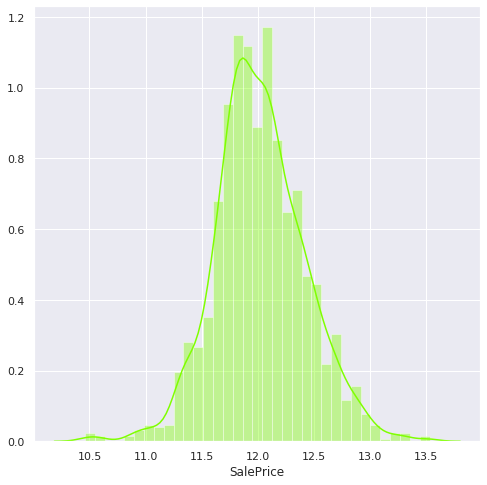

In [16]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['SalePrice'],color='chartreuse',hist=20)
#stats.probplot(train_df['SalePrice'],plot=plt)

In [17]:
train_df['SalePrice'].shape

(1458,)

**Correlation Analysis**

In [18]:
corre = train_df.corr()['SalePrice']
corre[np.argsort(corre,axis=0)[::-1]]

SalePrice        1.000000
OverallQual      0.821405
GrLivArea        0.725211
GarageCars       0.681033
GarageArea       0.656129
TotalBsmtSF      0.647563
1stFlrSF         0.620500
FullBath         0.595899
YearBuilt        0.587043
YearRemodAdd     0.565992
GarageYrBlt      0.541638
TotRmsAbvGrd     0.537702
Fireplaces       0.491998
MasVnrArea       0.434621
BsmtFinSF1       0.392283
LotFrontage      0.372900
WoodDeckSF       0.334251
OpenPorchSF      0.325215
2ndFlrSF         0.319953
HalfBath         0.314186
LotArea          0.260544
BsmtFullBath     0.237099
BsmtUnfSF        0.221892
BedroomAbvGr     0.209035
ScreenPorch      0.121245
PoolArea         0.074338
MoSold           0.057064
3SsnPorch        0.054914
BsmtFinSF2       0.004863
BsmtHalfBath    -0.005124
Id              -0.017774
MiscVal         -0.020012
OverallCond     -0.036821
YrSold          -0.037151
LowQualFinSF    -0.037951
MSSubClass      -0.073969
KitchenAbvGr    -0.147534
EnclosedPorch   -0.149029
Name: SalePr

**Plotting Correlation**

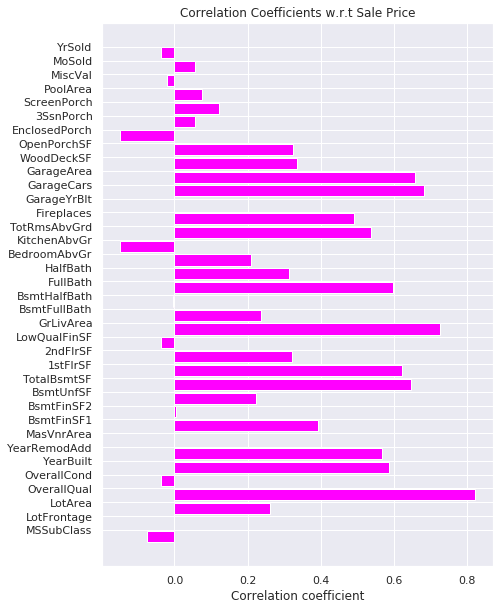

In [19]:
num_feat=train_df.columns[train_df.dtypes!=object]
num_feat=num_feat[1:-1] 
labels = []
values = []
for col in num_feat:
    labels.append(col)
    values.append(np.corrcoef(train_df[col].values, train_df.SalePrice.values)[0,1])
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(7,10))
rects = ax.barh(ind, np.array(values), color='magenta')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation Coefficients w.r.t Sale Price");

**Unique importance of Correlation**

In [20]:
correlations=train_df.corr()
attrs = correlations.iloc[:-1,:-1] # all except target

threshold = 0.5
important_corrs = (attrs[abs(attrs) > threshold][attrs != 1.0]) \
    .unstack().dropna().to_dict()

unique_important_corrs = pd.DataFrame(
    list(set([(tuple(sorted(key)), important_corrs[key]) \
    for key in important_corrs])), 
        columns=['Attribute Pair', 'Correlation'])

    # sorted by absolute value
unique_important_corrs = unique_important_corrs.ix[
    abs(unique_important_corrs['Correlation']).argsort()[::-1]]

unique_important_corrs

,Attribute Pair,Correlation
21,"(GarageArea, GarageCars)",0.887304
18,"(GrLivArea, TotRmsAbvGrd)",0.829498
24,"(GarageYrBlt, YearBuilt)",0.825317
26,"(1stFlrSF, TotalBsmtSF)",0.803830
5,"(2ndFlrSF, GrLivArea)",0.694678
13,"(BedroomAbvGr, TotRmsAbvGrd)",0.680390
1,"(BsmtFinSF1, BsmtFullBath)",0.658507
17,"(GarageYrBlt, YearRemodAdd)",0.641604
4,"(FullBath, GrLivArea)",0.638378
12,"(2ndFlrSF, TotRmsAbvGrd)",0.614034


This shows multicollinearity.<br>
In regression, "multicollinearity" refers to predictors that are correlated with other predictors.  Multicollinearity occurs when your model includes multiple factors that are correlated not just to your response variable, but also to each other. In other words, it results when you have factors that are a bit redundant.

Multicollinearity can handle by following method.<br>
1.Completely remove those variables <br>
2.Make new feature by adding them or by some other operation.<br>
3.Use PCA, which will reduce feature set to small number of non-collinear features.





**No or Little multicollinearity:**<br> Multicollinearity is when there is a strong correlation between independent variables. Linear regression or multilinear regression requires independent variables to have little or no similar features. Multicollinearity can lead to a variety of problems, including:

The effect of predictor variables estimated by our regression will depend on what other variables are included in our model.<br>
Predictors can have wildly different results depending on the observations in our sample, and small changes in samples can result in very different estimated effects.<br>
With very high multicollinearity, the inverse matrix, the computer calculates may not be accurate.<br>
We can no longer interpret a coefficient on a variable as the effect on the target of a one-unit increase in that variable holding the other variables constant. The reason behind that is, when predictors are strongly correlated, there is not a scenario in which one variable can change without a conditional change in another variable.

Observation.
As we can see, the multicollinearity still exists in various features. However, we will keep them for now for the sake of learning and lets models(e.x. Regularization models such as Lasso, Ridge) do the clean up later on. Let's go through some of the correlations that still exists.<br>

There is 0.83 or 83% correlation between GarageYrBlt and YearBuilt.<br>
83% correlation between TotRmsAbvGrd and GrLivArea.<br>
89% correlation between GarageCars and GarageArea.<br>
Similarly many other features such asBsmtUnfSF, FullBath have good correlation with other independent feature but not so much with the dependent feature.
 we will be using many algorithms as scikit learn modules makes it easy to implement them and get the best possible model. Therefore, we will keep all the features for now.

### Most correlated Features

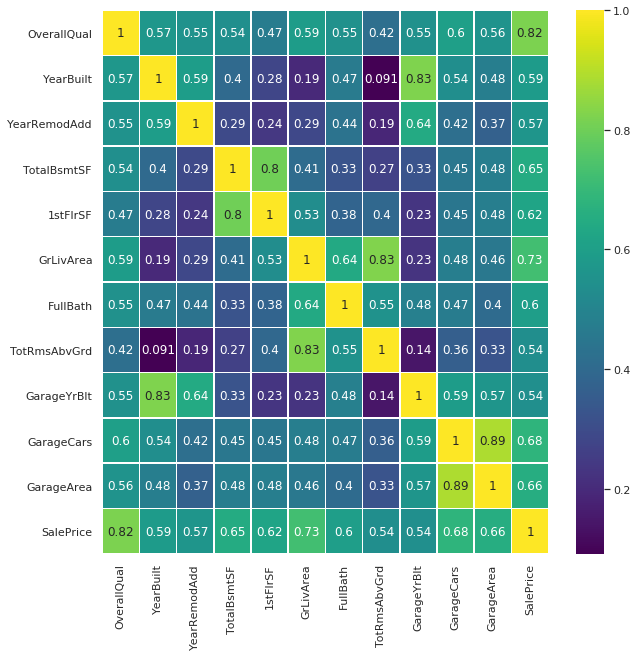

In [21]:
corremat = train_df.corr()
top_corr_features = corremat.index[(corremat['SalePrice'])> 0.5]
plt.figure(figsize=(10,10))
g= sns.heatmap(train_df[top_corr_features].corr(),annot=True,cmap='viridis',linewidths=.5)

In [22]:
most_corr = pd.DataFrame(top_corr_features)
most_corr.columns = ['Most Correlated Features']

most_corr

,Most Correlated Features
0,OverallQual
1,YearBuilt
2,YearRemodAdd
3,TotalBsmtSF
4,1stFlrSF
5,GrLivArea
6,FullBath
7,TotRmsAbvGrd
8,GarageYrBlt
9,GarageCars




Let's take a look at how each relates to Sale Price and do some pre-cleaning on each feature if necessary.

1.OverallQual: Rates the overall material and finish of the house (1 = Very Poor, 10 = Very Excellent)<br>
2	YearBuilt: Original construction date<br>
3	YearRemodAdd :Remodel date<br>
4	TotalBsmtSF: Total square feet of basement area<br>
5	1stFlrSF: First Floor square feet<br>
6	GrLivArea: Above grade (ground) living area square feet<br>
7	FullBath: Full bathrooms above grade<br>
8	TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)<br>
9	GarageCars: Size of garage in car capacity<br>
10	GarageArea: Size of garage in square feet<br>
11	SalePrice




### **visualization**

Now have a list of strongly correlated values but this list is incomplete as we know that correlation is affected by outliers. So we could proceed as follow:

Plot the numerical features and see which ones have very few or explainable outliers
Remove the outliers from these features and see which one can have a good correlation without their outliers
Btw, correlation by itself does not always explain the relationship between data so ploting them could even lead us to new insights and in the same manner, check that our correlated values have a linear relationship to the SalePrice.


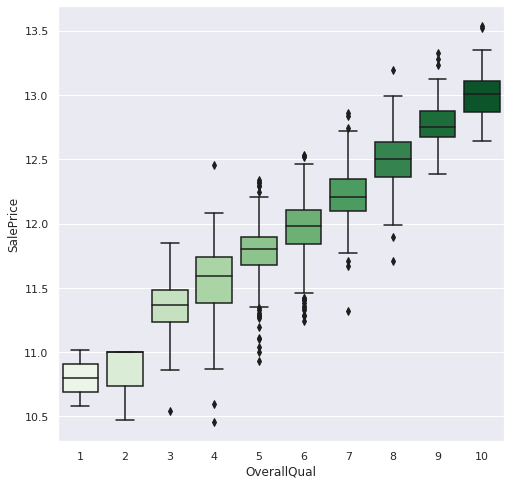

In [23]:
# Overall Quality vs Sale Price
data = pd.concat([train_df['SalePrice'], train_df['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 8))
fig = sns.boxplot(x='OverallQual', y="SalePrice", data=data,palette="Greens")


Sales price increase based on OverallQual increases.

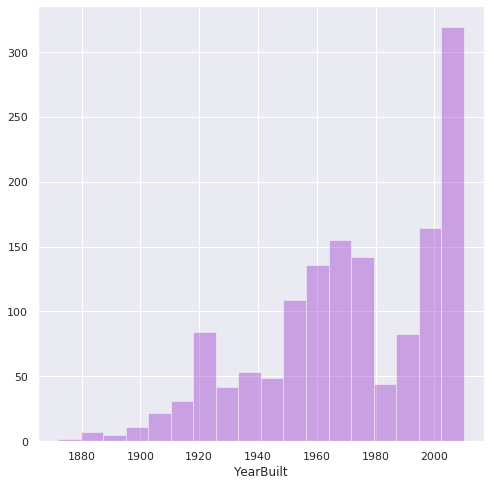

In [24]:
plt.figure(figsize=(8,8))
sns.distplot(train_df["YearBuilt"],color='darkorchid', kde=False,hist=10)

Although it seems like house prices decrease with age, we can't be entirely sure. Is it because of inflation or stock market crashes? Let's leave the years alone.

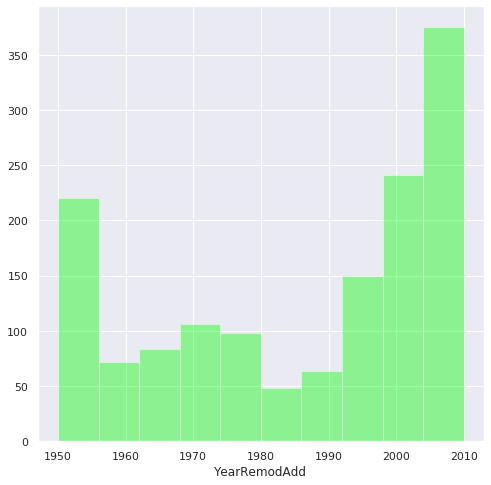

In [25]:
plt.figure(figsize=(8,8))
sns.distplot(train_df["YearRemodAdd"].astype(int),color='lime', kde=False);

<Figure size 720x720 with 0 Axes>

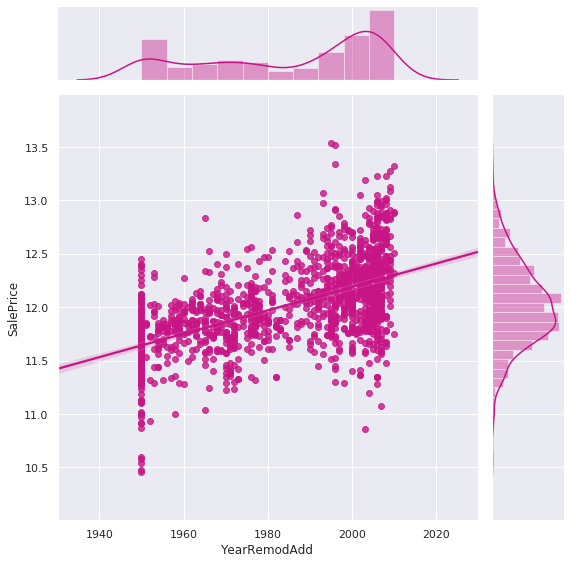

In [26]:
# Total Rooms vs Sale Price
plt.figure(figsize=(10,10))
sns.jointplot(x=train_df['YearRemodAdd'], y=train_df['SalePrice'],kind='reg',
              height=8,color= 'mediumvioletred')

Remodeling have very slight impact on sales price

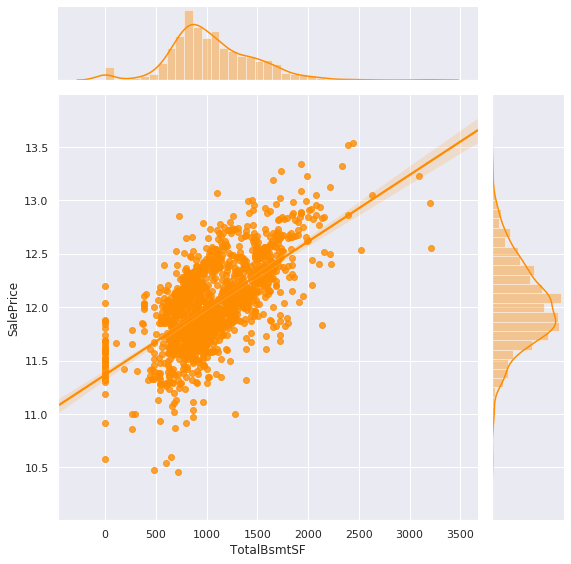

In [27]:
# Basement Area vs Sale Price
sns.jointplot(x=train_df['TotalBsmtSF'], y=train_df['SalePrice'], kind='reg',color='darkorange',
             height=8)


Sales price increase based on Basement area

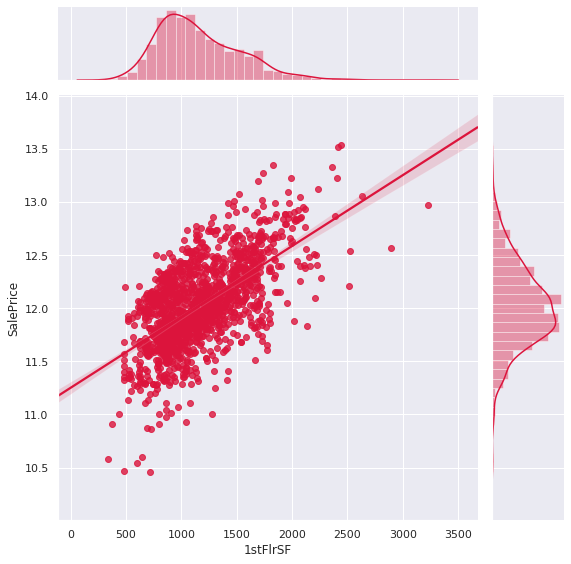

In [28]:
# First Floor Area vs Sale Price
sns.jointplot(x=train_df['1stFlrSF'], y=train_df['SalePrice'], kind='reg',color='crimson',height=8)

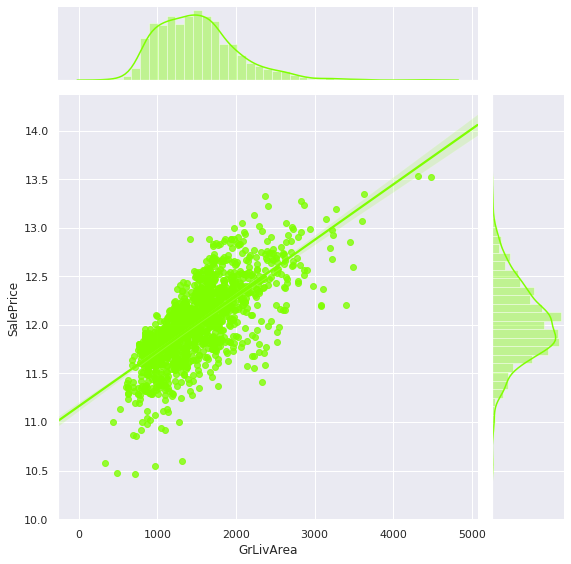

In [29]:
# Living Area vs Sale Price
sns.jointplot(x=train_df['GrLivArea'], y=train_df['SalePrice'], kind='reg',color='chartreuse',height=8)

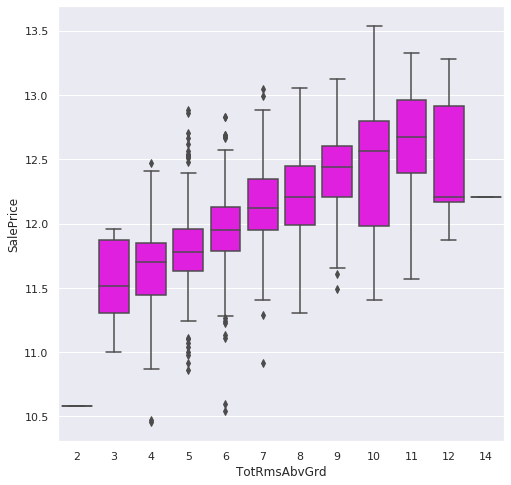

In [30]:
# Total Rooms vs Sale Price
plt.figure(figsize=(8,8))
sns.boxplot(x=train_df['TotRmsAbvGrd'], y=train_df['SalePrice'],color='fuchsia')

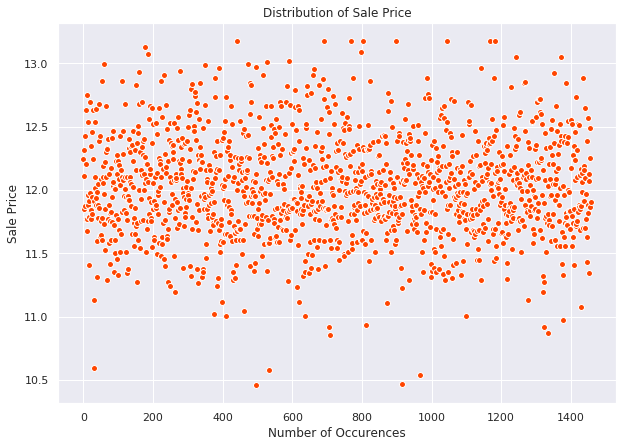

In [31]:
upperlimit = np.percentile(train_df.SalePrice.values, 99.5)
train_df['SalePrice'].ix[train_df['SalePrice']>upperlimit] = upperlimit
plt.figure(figsize=(10,7))
plt.scatter(range(train_df.shape[0]), train_df["SalePrice"].values,color='orangered',edgecolor='white')
plt.title("Distribution of Sale Price")
plt.xlabel("Number of Occurences")
plt.ylabel("Sale Price");

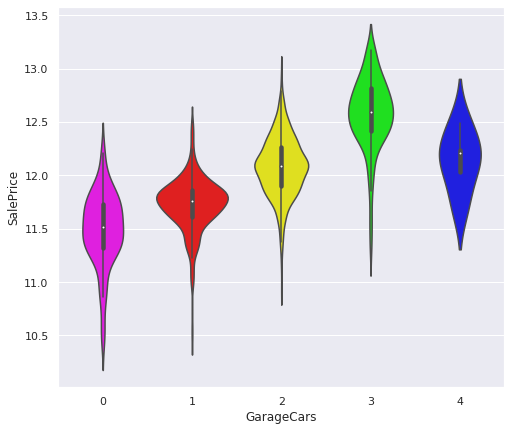

In [32]:
# Garage Area vs Sale Price
plt.figure(figsize=(8,7))
sns.violinplot(x=train_df['GarageCars'], y=train_df['SalePrice'],
               palette=['fuchsia','red','yellow','lime','blue'])


We need to remove the outliers the Garage area 4 as price is showing less compared to others

In [0]:
# Removing outliers 
train_df = train_df.drop(train_df[(train_df['GarageCars']>3) 
                         & (train_df['SalePrice']<350000)].index).reset_index(drop=True)

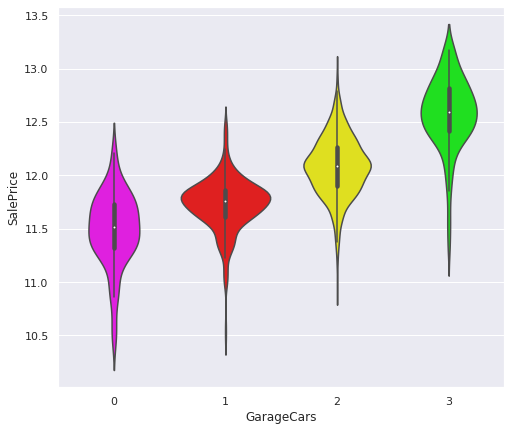

In [34]:
# Garage Area vs Sale Price after removing Outliers
plt.figure(figsize=(8,7))
sns.violinplot(x=train_df['GarageCars'], y=train_df['SalePrice'],
               palette=['fuchsia','red','yellow','lime'])

In [35]:
train_df.shape

(1453, 81)

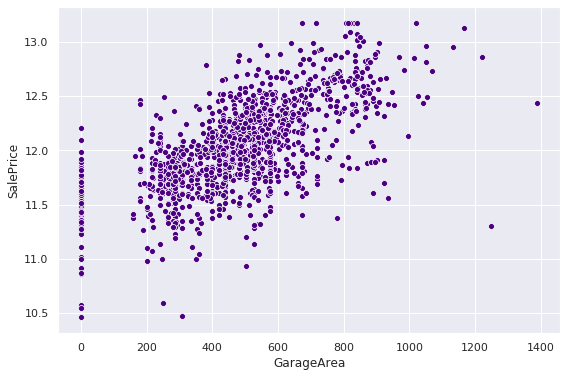

In [36]:
# Garage Area vs Sale Price
plt.figure(figsize=(9,6))
sns.scatterplot(x=train_df['GarageArea'], y=train_df['SalePrice'],color='indigo',edgecolor='white')

Please not Outliers extreme right down

In [0]:
deploy_df =train_df[['OverallQual' ,'YearBuilt','YearRemodAdd','TotalBsmtSF','1stFlrSF','GrLivArea','FullBath',
                     'TotRmsAbvGrd','GarageYrBlt','GarageCars','GarageArea','SalePrice']]

In [39]:
deploy_df

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageYrBlt,GarageCars,GarageArea,SalePrice
0,7,2003,2003,856,856,1710,2,8,2003.0,2,548,12.247699
1,6,1976,1976,1262,1262,1262,2,6,1976.0,2,460,12.109016
2,7,2001,2002,920,920,1786,2,6,2001.0,2,608,12.317171
3,7,1915,1970,756,961,1717,1,7,1998.0,3,642,11.849405
4,8,2000,2000,1145,1145,2198,2,9,2000.0,3,836,12.429220
...,...,...,...,...,...,...,...,...,...,...,...,...
1448,6,1999,2000,953,953,1647,2,7,1999.0,2,460,12.072547
1449,6,1978,1988,1542,2073,2073,2,7,1978.0,2,500,12.254868
1450,7,1941,2006,1152,1188,2340,2,9,1941.0,1,252,12.493133
1451,5,1950,1996,1078,1078,1078,1,5,1950.0,1,240,11.864469


## **Handling Missing Value**

 Handling the missing values is one of the greatest challenges faced by analysts, because making the right decision on how to handle it generates robust data models. Let us look at different ways of imputing the missing values.

1. Delete Row
<br>
This method commonly used to handle the null values. Here, we either delete a particular row if it has a null value for a particular feature and a particular column if it has more than 70-75% of missing values.

 



2. Replacing With Mean/Median/Mode 
<br>
This strategy can be applied on a feature which has numeric data 

3. Assigning An Unique Category
<br>
A categorical feature will have a definite number of possibilities.This strategy will add more information into the dataset which will result in the change of variance. Since they are categorical, we need to find one hot encoding to convert it to a numeric form for the algorithm to understand it

4. Predicting The Missing Values
<br>
Using the features which do not have missing values, we can predict the nulls with the help of a machine learning algorithm

5. Using Algorithms Which Support Missing Values
<br>
KNN is a machine learning algorithm which works on the principle of distance measure.
<br>
Ref:     https://analyticsindiamag.com/5-ways-handle-missing-values-machine-learning-datasets/

In [40]:
# It seems we have nulls so we will use the imputer strategy later on.
Missing = pd.DataFrame([deploy_df.isnull().sum()], ['train'])
Missing[Missing.sum(axis=1) > 0]

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageYrBlt,GarageCars,GarageArea,SalePrice
train,0,0,0,0,0,0,0,0,81,0,0,0


### Categorical &Numerical Data

In [42]:
deploy_df.select_dtypes(include=['object']).columns


Index([], dtype='object')

In [43]:
deploy_df.select_dtypes(exclude=['object']).columns

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'SalePrice'],
      dtype='object')

In [44]:
Categorical = len(deploy_df.select_dtypes(include=['object']).columns)
numerical = len(deploy_df.select_dtypes(exclude=['object']).columns)
print('Categorical:',Categorical)
print('Numerical:',numerical)

Categorical: 0
Numerical: 12


In [45]:
corre = deploy_df.corr()['SalePrice']
corre[np.argsort(corre,axis=0)[::-1]]

SalePrice       1.000000
OverallQual     0.822532
GrLivArea       0.721133
GarageCars      0.690516
GarageArea      0.661295
TotalBsmtSF     0.645466
1stFlrSF        0.618473
FullBath        0.596192
YearBuilt       0.593831
YearRemodAdd    0.568291
GarageYrBlt     0.545543
TotRmsAbvGrd    0.536716
Name: SalePrice, dtype: float64

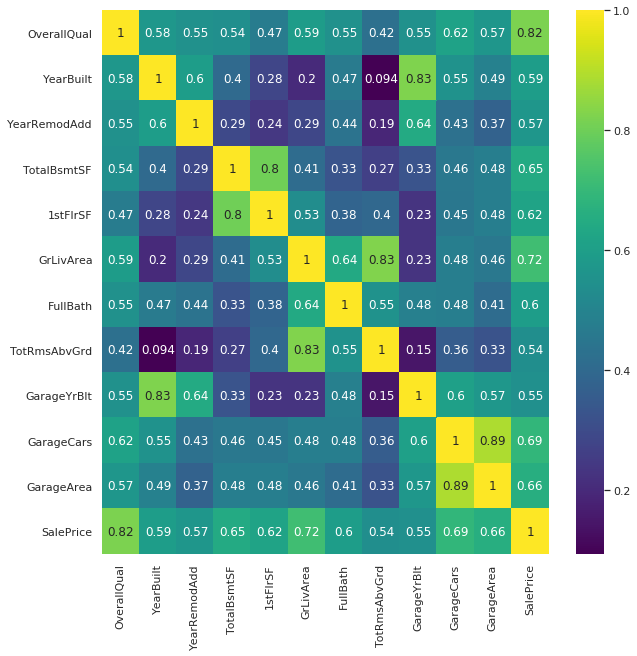

In [46]:
corremat = deploy_df.corr()
top_corr_features = corremat.index[(corremat['SalePrice'])> 0.5]
plt.figure(figsize=(10,10))
g= sns.heatmap(deploy_df[top_corr_features].corr(),annot=True,cmap='viridis')

In [0]:
target_feature = deploy_df['SalePrice']

In [0]:
train_feature = deploy_df.drop(['SalePrice'], axis=1).reset_index(drop=True)
#test_features = test_df
#total_features = pd.concat([train_features, test_features]).reset_index(drop=True)

In [49]:
train_feature.head(3)

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageYrBlt,GarageCars,GarageArea
0,7,2003,2003,856,856,1710,2,8,2003.0,2,548
1,6,1976,1976,1262,1262,1262,2,6,1976.0,2,460
2,7,2001,2002,920,920,1786,2,6,2001.0,2,608


In [0]:
## Missing data in GarageYrBit most probably means missing Garage , so replace NaN with zero . 
train_feature['GarageYrBlt'] = train_feature['GarageYrBlt'].fillna(0)

For missing values in numerical cols , we fillNa with 0.

In [51]:
train_feature.isnull().sum()

OverallQual     0
YearBuilt       0
YearRemodAdd    0
TotalBsmtSF     0
1stFlrSF        0
GrLivArea       0
FullBath        0
TotRmsAbvGrd    0
GarageYrBlt     0
GarageCars      0
GarageArea      0
dtype: int64

### **Feature Engineering**

In [0]:
#######################################################################################
# Adding new features . Make sure that you understand this. 
#train_feature['YrBltAndRemod']=train_feature['YearBuilt']+train_feature['YearRemodAdd']
#train_feature['TotalSF']=train_feature['TotalBsmtSF'] + train_feature['1stFlrSF'] 
########################################################################################

In [105]:
train_feature.shape

(1453, 11)

In [53]:
numeric_feats = train_feature.dtypes[train_feature.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = train_feature[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
GrLivArea,1.012973
1stFlrSF,0.890436
TotRmsAbvGrd,0.650194
TotalBsmtSF,0.514004
OverallQual,0.201107
GarageArea,0.089154
FullBath,0.029791
GarageCars,-0.422533
YearRemodAdd,-0.502596
YearBuilt,-0.603603


Not highly skewed

In [0]:
X_train = train_feature 

In [0]:
y_train = target_feature

In [57]:
y_train

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1448    12.072547
1449    12.254868
1450    12.493133
1451    11.864469
1452    11.901590
Name: SalePrice, Length: 1453, dtype: float64

In [58]:
X_train.shape,y_train.shape

((1453, 11), (1453,))

In [60]:
X_train.head(4)

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageYrBlt,GarageCars,GarageArea
0,7,2003,2003,856,856,1710,2,8,2003.0,2,548
1,6,1976,1976,1262,1262,1262,2,6,1976.0,2,460
2,7,2001,2002,920,920,1786,2,6,2001.0,2,608
3,7,1915,1970,756,961,1717,1,7,1998.0,3,642


**Linear Regression**

In [0]:
#Train the model

lin_model = linear_model.LinearRegression()

In [62]:
#Fit the model
lin_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [63]:
linear_accuracy = round(lin_model.score(X_train,y_train)*100,2)
print(round(linear_accuracy,2),'%')

85.74 %


In [0]:
#Train the model

random_model = RandomForestRegressor(n_estimators=1000)

In [65]:
#Fit
random_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [66]:
random_accuracy = round(random_model.score(X_train,y_train)*100,2)
print(round(random_accuracy,2),'%')

97.91 %


GradientBoostingRegressor

In [0]:
#Train the model

GBR_model = GradientBoostingRegressor(n_estimators=100, max_depth=4)

In [68]:
#Fit
GBR_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [69]:
GBR_accuracy = round(GBR_model.score(X_train,y_train)*100,2)
print(round(GBR_accuracy,2),'%')

94.18 %


### This high accuracy may be misleading because of multicollinearity,letus consider that as well.

In [0]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

**Define a cross validation strategy**

Cross Validation is used to assess the predictive performance of the models and and to judge how they perform outside the sample to a new data set also known as test data
The motivation to use cross validation techniques is that when we fit a model, we are fitting it to a training dataset. Without cross validation we only have information on how does our model perform to our in-sample data. Ideally we would like to see how does the model perform when we have a new data in terms of accuracy of its predictions. In science, theories are judged by its predictive performance.  

We use the cross_val_score function of Sklearn. However this function has not a shuffle attribut, we add then one line of code, in order to shuffle the dataset prior to cross-validation

In [0]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train.values, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### **Regularization Models**<br>
What makes regression model more effective is its ability of regularizing. The term "regularizing" stands for models ability to structurally prevent overfitting by imposing a penalty on the coefficients.<br>

There are three types of regularizations.<br>

Ridge <br>
Lasso <br>
Elastic Net <br>
These regularization methods work by penalizing the magnitude of the coefficients of features and at the same time minimizing the error between the predicted value and actual observed values. This minimization becomes a balance between the error (the difference between the predicted value and observed value) and the size of the coefficients. The only difference between Ridge and Lasso is the way they penalize the coefficients. Elastic Net is the combination of these two. Elastic Net adds both the sum of the squares errors and the absolute value of the squared error. 

### **LASSO Regression **

Lasso regression is a type of linear regression that uses shrinkage. Shrinkage is where data values are shrunk towards a central point, like the mean. The lasso procedure encourages simple, sparse models (i.e. models with fewer parameters). This particular type of regression is well-suited for models showing high levels of muticollinearity or when you want to automate certain parts of model selection, like variable selection/parameter elimination.

The acronym “LASSO” stands for Least Absolute Shrinkage and Selection Operator.

In [0]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

### Kernel Ridge Regression :

It is essential to standardize the predictor variables before constructing the models.
It is important to check for multicollinearity,

In [0]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)


### Elastic Net Regression :

Elastic net is always preferred over lasso & ridge regression because it solves the limitations of both methods, while also including each as special cases. So if the ridge or lasso solution is, indeed, the best, then any good model selection routine will identify that as part of the modeling process.

In [0]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

### **bagging, boosting and stacking**

In ensemble learning theory, we call weak learners (or base models) models that can be used as building blocks for designing more complex models by combining several of them

We can mention three major kinds of meta-algorithms that aims at combining weak learners:<br>
bagging, that often considers homogeneous weak learners, learns them independently from each other in parallel and combines them following some kind of deterministic averaging process.<br>
boosting, that often considers homogeneous weak learners, learns them sequentially in a very adaptative way (a base model depends on the previous ones) and combines them following a deterministic strategy.<br>
stacking, that often considers heterogeneous weak learners, learns them in parallel and combines them by training a meta-model to output a prediction based on the different weak models predictions

we can say that bagging will mainly focus at getting an ensemble model with less variance than its components whereas boosting and stacking will mainly try to produce strong models less biased than their components (even if variance can also be reduced).

### Gradient Boosting Regression :

Gradient boosting is a  technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do


In [0]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

### XGBoost :

XGBoost is an algorithm that has recently been dominating applied machine learning  for structured or tabular data.

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.It is a more advanced version of the gradient boosting method. The main aim of this algorithm is to increase speed and to increase the efficiency of your competitions

In [0]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

### LightGBM :
Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm, used for ranking, classification and many other machine learning tasks.

In [0]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

Base models scores <br>
Let's see how these base models perform on the data by evaluating the cross-validation rmsle error

In [87]:
score_lasso = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score_lasso.mean(), score_lasso.std()))


Lasso score: 0.1514 (0.0026)



In [88]:
score_Enet = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score_Enet.mean(), score_Enet.std()))

ElasticNet score: 0.1514 (0.0026)



In [89]:
score_KRR = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score_KRR.mean(), score_KRR.std()))

Kernel Ridge score: 0.1513 (0.0065)



In [91]:
score_GBoost = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score_GBoost.mean(), score_GBoost.std()))

Gradient Boosting score: 0.1570 (0.0086)



In [92]:
score_xgb = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score_xgb.mean(), score_xgb.std()))

Xgboost score: 0.1494 (0.0069)



In [93]:
score_lgb = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score_lgb.mean(), score_lgb.std()))

LGBM score: 0.1496 (0.0062)



In [0]:
y_train =np.expm1(y_train)

In [103]:
model_lgb.fit(X_train,y_train)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.2319, feature_fraction_seed=9,
              importance_type='split', learning_rate=0.05, max_bin=55,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=6, min_split_gain=0.0,
              min_sum_hessian_in_leaf=11, n_estimators=720, n_jobs=-1,
              num_leaves=5, objective='regression', random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [0]:
y_pred = model_lgb.predict(X_train)

In [105]:
y_pred

array([195139.0476389 , 159917.57468451, 209707.81664523, ...,
       253702.41419117, 133593.91620849, 142073.48827726])

***I hope you enjoyed this notebook.***